In [1]:
import math
import torch
import ntwrk
from ntwrk.bayesopt import BayesOpt, expected_improvement, max_mean

import gym
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import numpy as np
import matplotlib.pyplot as plt

## Let's Try Bayesian Optimization

#### Make Network

In [2]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

#### set up phase

In [3]:
max_jump = 2.
n_start = 3
deltas = torch.rand(n_start) * 2*max_jump - max_jump
rwrds = torch.zeros(n_start)
for dind, dd in enumerate(deltas):
    rwrds[dind] = env.step(dd.unsqueeze(-1))[1].item()
    print(dd)


avg latency
0.7100809102992218


tensor(1.4082)
avg latency
0.710080910299222


tensor(-0.1762)
avg latency
0.710080910299222


tensor(0.2920)


In [4]:
deltas

tensor([ 1.4082, -0.1762,  0.2920])

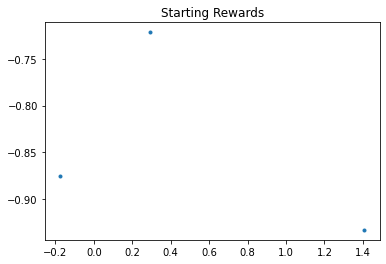

In [5]:
plt.plot(deltas, rwrds, marker='.', linestyle="None")
plt.title("Starting Rewards")
plt.show()

In [6]:
deltas

tensor([ 1.4082, -0.1762,  0.2920])

In [7]:
bo = BayesOpt(deltas, rwrds, normalize=True, max_delta=max_jump, acquisition=expected_improvement)

In [8]:
rnds = 10
saved_rwrds = torch.zeros(rnds)
saved_deltas = torch.zeros(rnds)
test_points = torch.linspace(-max_jump, max_jump)
# test_points = torch.arange(1, 1000).float().div(max_x)
for ii in range(rnds):
    bo.train_surrogate(iters=500, overwrite=True)
    next_rate = bo.acquire(explore=0.1).unsqueeze(0)
    print(next_rate.shape)
    print("next rate = ", next_rate)
    rwrd = torch.tensor(env.step(next_rate)[1]).unsqueeze(0)
    saved_rwrds[ii] = rwrd.item()
    bo.update_obs(next_rate, rwrd, max_obs=4)
    

torch.Size([1])
next rate =  tensor([-1.9196])
avg latency
0.710080910299222


torch.Size([1])
next rate =  tensor([0.7136])
avg latency
0.710080910299222


torch.Size([1])
next rate =  tensor([0.2111])
avg latency
0.710080910299222


torch.Size([1])
next rate =  tensor([1.6985])
avg latency
0.710080910299222


torch.Size([1])
next rate =  tensor([1.2563])
avg latency
0.710080910299222


torch.Size([1])
next rate =  tensor([1.0955])
avg latency
0.710080910299222


torch.Size([1])
next rate =  tensor([1.1558])
avg latency
0.7100809102992219


torch.Size([1])
next rate =  tensor([-1.8995])
avg latency
0.7100809102992219


torch.Size([1])
next rate =  tensor([1.3769])
avg latency
0.7100809102992219


torch.Size([1])
next rate =  tensor([1.3769])
avg latency
0.710080910299222




In [9]:
torch.save("saved_rwrds.pt", saved_rwrds)

AttributeError: 'Tensor' object has no attribute 'flush'